# Front Matter

* CASA0013 - Introduction to Programming for Spatial Analysts (20/21)
* Student ID: 20198890 
* **AirBnb Host-Revenue and Booking Rate Prediction Model for Selected Boroughs in London**
* Word Count including graphs as 250 words: 2458


# Executive Summary

This report provide a detailed analysis of AirBnb listings in the selected boroughs of London in terms of revenue and booking rate. The data is taken from InsideAirbnb website ( November 05th, 2019 ) and contained detailed listings data and calendar data of current listings. The aim of this report is guiding newcomer hosts to Airbnb platform so that they can maximise their revenues and booking rate by modelling good pricing strategy, house property and policy. Relying on LightGBM and correlation methodology to analyse Airbnb data, there are several key findings in this report: 

* Westminster with 9588 listings is the borough with the highest number of lists. The next two are Tower Hamlets with 8246 and Hackney with 6276 listings. 

* However, in terms of average price, the first rank belongs to Kensington and Chelsea with 6018 number of listings and 217 USD average price. The next two are Westminster with 9588 number of listings and 216 USD average price and City of London with 465 number of listings and 190 USD average price. This report will look at the top three boroughs with highest average price and first assumption of this report is newcomers will publish host in these boroughs. 

* When we look at price-time and booking rate-time relationships for these boroughs, interestingly, average price and booking rate peak in winter time. In summer time, there is slightly increase in average price. 

* While daily revenue is correlated mostly with property details such as number of bedrooms, bathrooms, room and house type, booking rate is relatively correlated with price per person and accommodates with a significantly low percentage. 

* As a most important part of this report, LightGBM model will be established in order to predict booking rate and revenue according to input parameters. 

* As a result of this analysis, for revenue, the price features are the most important parameters such as price surge and price per person, cleaning fee and standart derivation of actual price. Property details and cancellation policy can have little effect on revenue. Interestingly, neighbourhood almost does not affect revenue. 

* For booking rate, again, price features are the most important factors. However, according to result, cleaning fee percent is most effective factor on booking probability. Different to price features, maximum and minimum night and property details are also important factos. 

# Reproducible Analysis

### Installing additional libraries

In [1]:
pip install utils

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


### Import Library

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb

from utils import *

from collections import Counter
import sklearn.metrics as metrics
from sklearn import metrics
from sklearn import datasets
from sklearn import linear_model
from sklearn import ensemble
from IPython.core.display import HTML

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [4]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['font.size'] = 15
random.seed(0)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [5]:
#listing_data = pd.read_csv("Data/listings.csv.gz", compression='gzip', low_memory=False)

In [6]:
listing_data = pd.read_csv("https://github.com/ucfnofe/i2pcoursework/blob/master/Data/listings.csv.gz?raw=true", compression='gzip', low_memory=False)

In [7]:
#calendar_data = pd.read_csv("Data/calendar.csv.gz", compression='gzip', low_memory=False)

In [8]:
calendar_data = pd.read_csv("https://github.com/ucfnofe/i2pcoursework/blob/master/Data/calendar_data_1.csv.gz?raw=true", compression='gzip', error_bad_lines = False, low_memory=False, parse_dates=['date'])

In [9]:
calendar_data.head(2)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,isin
0,90700,2019-11-06,f,$125.00,$125.00,90.0,1125.0,True
1,90700,2019-11-07,f,$125.00,$125.00,90.0,1125.0,True


In [10]:
#calendar_data = pd.read_csv("Data/calendar.csv", parse_dates=['date'])

In [11]:
listing_data.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20191105115249,2019-11-06,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,"Amenities Bedding: 1 Double bed, 1 living room...",Unlike most rental apartments out there my fla...,family,Not even 10 minutes by metro from Victoria Sta...,No Smoking (very strict) Check-in time is afte...,Tons of buses (24hrs) go into central London f...,Guest will have access to the entire apartment,No interaction with guests as you book the ent...,No Smoking (very strict) No pets are allowed i...,NaN,NaN,https://a0.muscache.com/im/pictures/1d720898-c...,NaN,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Brixton,Lambeth,NaN,London,NaN,SW9 8DG,London,"London, United Kingdom",GB,United Kingdom,51.46225,-0.11732,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",NaN,$88.00,$645.00,"$2,350.00",$400.00,$30.00,2,$20.00,3,180,3,3,180,180,3.0,180.0,4 days ago,t,17,41,61,336,2019-11-06,185,2,2010-03-21,2019-09-15,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,f,strict_14_with_grace_period,f,t,2,2,0,0,1.58
1,38151,https://www.airbnb.com/rooms/38151,20191105115249,2019-11-06,Double room/ lounge,NaN,"Comfortable, large double room /lounge area av...","Comfortable, large double room /lounge area av...",none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/214176/451...,NaN,163634,https://www.airbnb.com/users/show/163634,Lisa,2010-07-11,GB,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,Crystal Palace,1.0,1.0,['phone'],f,f,"Upper Norwood, Surrey, United Kingdom",LB of Croydon,Croydon,NaN,Upper Norwood,Surrey,SE19 3EJ,London,"Upper Norwood, United Kingdom",GB,United Kingdom,51.41940,-0.08722,f,Apartment,Private room,2,NaN,1.0,NaN,Real Bed,{},NaN,$65.00,NaN,NaN,NaN,NaN,1,$0.00,1,730,1,1,730,730,1.0,730.0,never,t,30,60

### Selecting Neighbourhoods

In [12]:
# using Counter to analyze frequency of each listing based on neighborhood
nh = Counter(listing_data['neighbourhood_cleansed'])
testnh= pd.DataFrame.from_dict(nh, orient='index').reset_index()
testnh = testnh.sort_values('index').reset_index()

<AxesSubplot:title={'center':'SF Neighborhood Frequency'}>

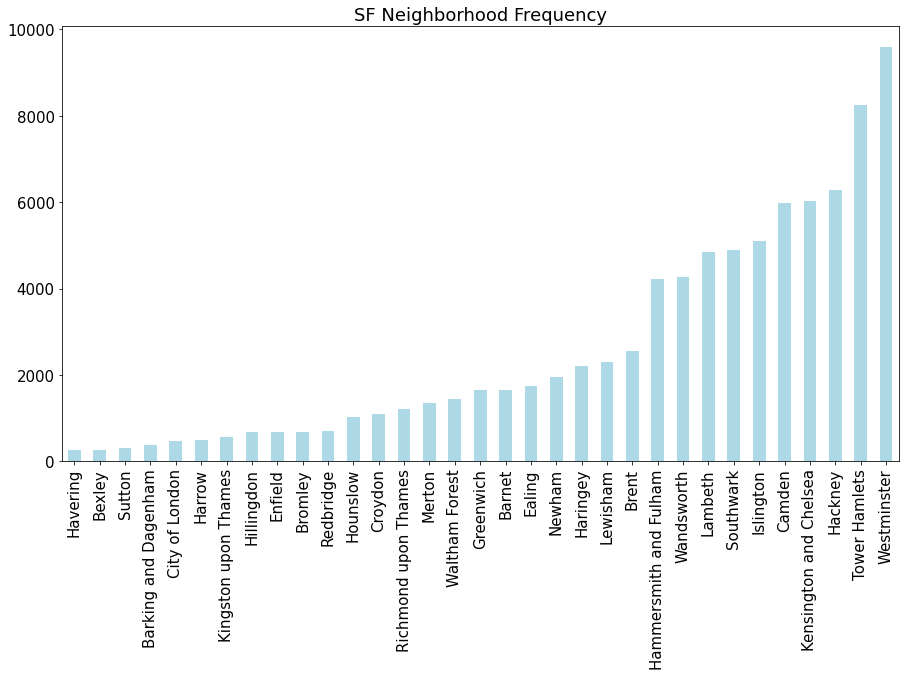

In [13]:
nh_df = pd.DataFrame.from_dict(nh, orient='index').sort_values(by=0)
nh_df.plot(kind='bar', 
           color = 'LightBlue', 
           figsize =(15,8), 
           title = 'SF Neighborhood Frequency', 
           legend = False)

Tranforming price data from string to float

In [14]:
listing_data['price'] = listing_data['price'].replace('[\$,]', '', regex=True).astype(float)
listing_data['cleaning_fee'] = listing_data['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
listing_data['extra_people'] = listing_data['extra_people'].replace('[\$,]', '', regex=True).astype(float)
listing_data['price'] = listing_data['price'].fillna(0)

Let's calculate total average price

In [15]:
average_price = sum(listing_data.price) / float(len(listing_data.price))
average_price

122.33676588141252

In [16]:
# 2 column table of neighborhood names and prices
nh_df = listing_data[['neighbourhood_cleansed', 'price']]
nh_df.columns = ['neighbourhood', 'price']

# group by neighbourhood and then aggreate the prices based on mean
nh_df_group = nh_df.groupby('neighbourhood')
nh_df = nh_df_group['price'].agg(np.mean)

# turn dictionary's keys and values into a table for easy read
nh_df = nh_df.reset_index()
nh_df["number of listings"] = testnh[0]
nh_df

,neighbourhood,price,number of listings
0,Barking and Dagenham,60.529570,372
1,Barnet,87.685955,1659
2,Bexley,62.706320,269
3,Brent,93.089028,2561
4,Bromley,64.260677,679
5,Camden,144.404722,5972
6,City of London,190.774194,465
7,Croydon,63.488688,1105
8,Ealing,79.732112,1747
9,Enfield,65.466568,673


Plotting listings in Airbnb according to neighbourhood and price

<AxesSubplot:title={'center':'Price per Neighorhood'}, xlabel='neighbourhood'>

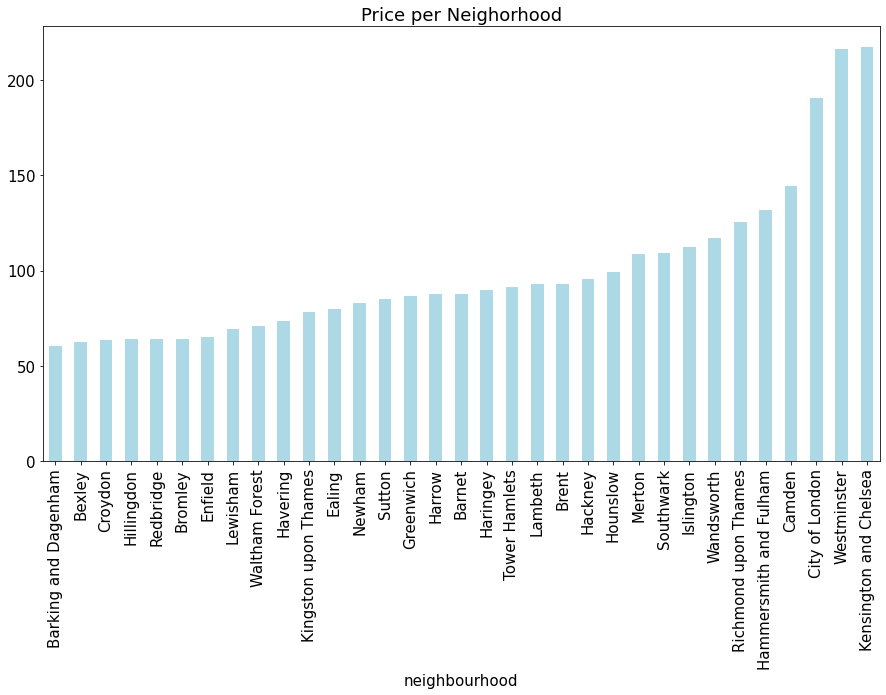

In [17]:
p = nh_df.sort_values(by = 'price')
p.plot(x = "neighbourhood",
       y = "price",
       kind='bar', 
       color = 'LightBlue', 
       figsize =(15,8), 
       title = 'Price per Neighorhood', 
       legend = False)

### Sorting Selected Neighbourhoods from Calendar and Listing DataFrames

In [18]:
listing_data_three_boroughs = listing_data[(listing_data["neighbourhood_cleansed"] == "City of London") | (listing_data["neighbourhood_cleansed"] == "Westminster") | (listing_data["neighbourhood_cleansed"] == "Kensington and Chelsea")]
listing_data_three_boroughs["neighbourhood_cleansed"] = listing_data["neighbourhood_cleansed"][(listing_data["neighbourhood_cleansed"] == "City of London") | (listing_data["neighbourhood_cleansed"] == "Westminster") | (listing_data["neighbourhood_cleansed"] == "Kensington and Chelsea")]
listing_data_three_boroughs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16071 entries, 4 to 85067
Columns: 106 entries, id to reviews_per_month
dtypes: float64(26), int64(21), object(59)
memory usage: 13.1+ MB


In [19]:
listing_data_three_boroughs.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
4,90700,https://www.airbnb.com/rooms/90700,20191105115249,2019-11-06,Sunny Notting Hill flat & terrace,This is a home not a hotel - for the cost gues...,This charming 1 bedroom with en-suite bathroom...,This is a home not a hotel - for the cost gues...,none,A quick guide or a run through about the area ...,Please note check in is at 4pm and check out i...,NaN,The whole place is for our guests to enjoy.,Apart from check in and check out we find that...,Full rules will be provided on arrival but the...,NaN,NaN,https://a0.muscache.com/im/pictures/10769138/4...,NaN,491286,https://www.airbnb.com/users/show/491286,Chil,2011-04-07,"London, England, United Kingdom",I am a curator working for a gallery in Mayfai...,within a day,86%,NaN,f,https://a0.muscache.com/im/users/491286/profil...,https://a0.muscache.com/im/users/491286/profil...,Notting Hill,2.0,2.0,"['email', 'phone', 'reviews', 'offline_governm...",t,f,"Kensington, England, United Kingdom",Notting Hill,Kensington and Chelsea,NaN,Kensington,England,W11 3,London,"Kensington, United Kingdom",GB,United Kingdom,51.51074,-0.19853,t,House,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,Heating,Washer,Essentia...",NaN,105.0,NaN,NaN,$0.00,35.0,2,10.0,2,1125,2,90,1125,1125,14.1,1125.0,5 weeks ago,t,0,0,24,268,2019-11-06,339,33,2011-06-27,2019-07-30,88.0,9.0,9.0,10.0,10.0,10.0,9.0,f,NaN,NaN,t,f,strict_14_with_grace_period,f,f,2,2,0,0,3.33
5,15400,https://www.airbnb.com/rooms/15400,20191105115249,2019-11-06,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,The building next door is in the process of be...,The underground stations are South Kensington ...,There are two wardrobes for guests exclusive u...,If I am in the country I like to welcome my gu...,NO SMOKING PLEASE.. No unauthorised guests. No...,NaN,NaN,https://a0.muscache.com/im/pictures/428392/462...,NaN,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/pr

In [20]:
calendar_data["isin"] = calendar_data["listing_id"].isin(listing_data_three_boroughs["id"])
indexNames = calendar_data[calendar_data['isin'] == False ].index
calendar_data.drop(indexNames , inplace=True)

In [21]:
calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5865960 entries, 0 to 5865959
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
 7   isin            bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 363.6+ MB


In [22]:
#calendar_data.to_csv('Data/calendar_data_for_three_boroughs.csv')

In [23]:
# Calendar data
calendar_data['price'] = calendar_data['price'].replace('[\$,]', '', regex=True).astype(float)
calendar_data['available'] = calendar_data['available'].map({'t':1, 'f':0})
calendar_data['revenue'] = calendar_data['price']*calendar_data['available']

### Revenue and Booking Overview for selected neighbourhoods

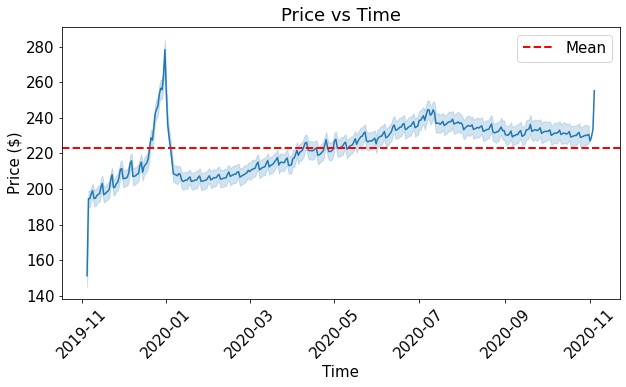

In [24]:
ax = sns.lineplot(x = "date", y = "price", 
                  markers = True, dashes = False, data = calendar_data)
plt.axhline(calendar_data['price'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation = 45)
plt.title('Price vs Time')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend(loc='best')

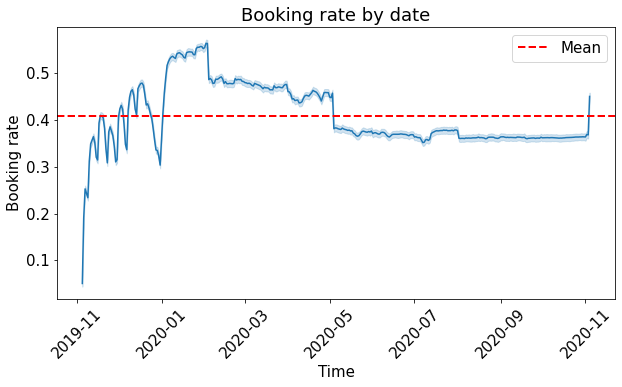

In [25]:
ax = sns.lineplot(x = "date", y = "available", 
                  markers = True, dashes = False, data = calendar_data)
plt.axhline(calendar_data['available'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation = 45)
plt.title('Booking rate by date')
plt.xlabel('Time')
plt.ylabel('Booking rate')
plt.legend(loc='best')

In [26]:
# Revenue Overview Calculations
calendar_data = calendar_data.fillna(0)
overview_revenue = calendar_data.groupby('listing_id')['available','price'].mean()
overview_revenue.columns = ['booking_rate(%)', 'daily_revenue']
overview_revenue['booking_rate(%)'] = overview_revenue['booking_rate(%)']*100

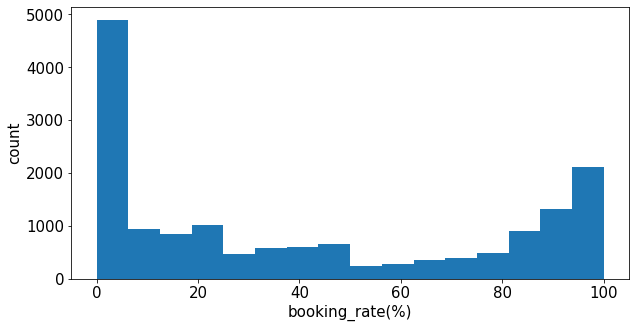

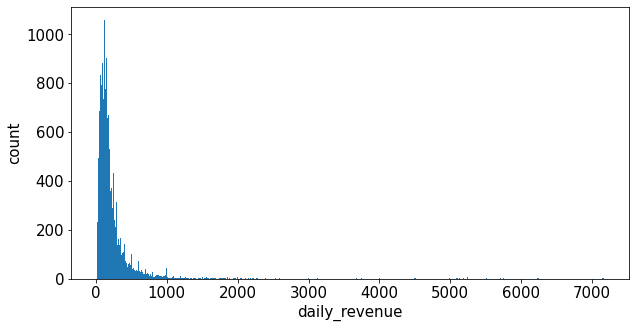

In [27]:
for col in overview_revenue.columns:
    plt.figure()
    plt.hist(overview_revenue[col], bins='auto')
    plt.xlabel(col)
    plt.ylabel('count')

In [28]:
print('Average daily revenue: %f $' %np.mean(overview_revenue['daily_revenue']))

Average daily revenue: 223.254064 $


In [29]:
# Calculation price mean and standart derivation
calendar_booked = calendar_data[calendar_data['price']!=0]
calendar_booked = calendar_booked.groupby('listing_id').agg({'price':['mean','std']}).reset_index()
calendar_booked.columns=['listing_id','price_avg','price_std']

In [30]:
calendar_booked.head()

,listing_id,price_avg,price_std
0,15400,75.000000,0.000000
1,17402,311.273973,12.751061
2,39387,46.150685,4.520014
3,45168,125.000000,0.000000
4,46961,73.668493,14.534620


### Data Preparation for Analysis

In [31]:
property_details = ['bathrooms', 'bedrooms', 'beds', 'room_type', 'accommodates', 'bed_type','property_type','neighbourhood_cleansed']
host_details = ['guests_included','minimum_nights', 'maximum_nights','cancellation_policy','require_guest_phone_verification',
                 'require_guest_profile_picture','host_has_profile_pic', 'host_identity_verified']
pricing_details = ['price','cleaning_fee','extra_people']

In [32]:
# Overall
all_columns_name = ['id'] + property_details + host_details + pricing_details 
listing_data_three_boroughs = listing_data_three_boroughs[all_columns_name]

In [33]:
listing_data_three_boroughs.head()

,id,bathrooms,bedrooms,beds,room_type,accommodates,bed_type,property_type,neighbourhood_cleansed,guests_included,minimum_nights,maximum_nights,cancellation_policy,require_guest_phone_verification,require_guest_profile_picture,host_has_profile_pic,host_identity_verified,price,cleaning_fee,extra_people
4,90700,1.0,1.0,1.0,Entire home/apt,2,Real Bed,House,Kensington and Chelsea,2,2,1125,strict_14_with_grace_period,f,f,t,f,105.0,35.0,10.0
5,15400,1.0,1.0,1.0,Entire home/apt,2,Real Bed,Apartment,Kensington and Chelsea,2,30,50,strict_14_with_grace_period,t,t,t,t,100.0,50.0,0.0
7,17402,2.0,3.0,3.0,Entire home/apt,6,Real Bed,Apartment,Westminster,4,3,365,strict_14_with_grace_period,f,f,t,t,300.0,65.0,10.0
15,39387,1.0,1.0,1.0,Private room,2,Futon,Apartment,Westminster,1,5,10,moderate,f,f,t,f,49.0,15.0,10.0
19,93783,2.0,2.0,3.0,Entire home/apt,4,Real Bed,Apartment,Westminster,4,2,365,strict_14_with_grace_period,t,f,t,f,300.0,100.0,50.0


In [34]:
# Merging two processed dataFrame
listing_data_three_boroughs = pd.merge(listing_data_three_boroughs, overview_revenue, how='left', left_on='id', right_on='listing_id')
listing_data_three_boroughs = pd.merge(listing_data_three_boroughs, calendar_booked, how='left', left_on='id', right_on='listing_id')
listing_data_three_boroughs = listing_data_three_boroughs.drop(['listing_id'], axis=1)
listing_data_three_boroughs['price_per_person'] = listing_data_three_boroughs['price']/listing_data_three_boroughs['accommodates']
pricing_details = pricing_details + ['price_avg','price_std', 'price_per_person']

listing_data_three_boroughs.head()

,id,bathrooms,bedrooms,beds,room_type,accommodates,bed_type,property_type,neighbourhood_cleansed,guests_included,minimum_nights,maximum_nights,cancellation_policy,require_guest_phone_verification,require_guest_profile_picture,host_has_profile_pic,host_identity_verified,price,cleaning_fee,extra_people,booking_rate(%),daily_revenue,price_avg,price_std,price_per_person
0,90700,1.0,1.0,1.0,Entire home/apt,2,Real Bed,House,Kensington and Chelsea,2,2,1125,strict_14_with_grace_period,f,f,t,f,105.0,35.0,10.0,73.424658,125.000000,125.000000,0.000000,52.5
1,15400,1.0,1.0,1.0,Entire home/apt,2,Real Bed,Apartment,Kensington and Chelsea,2,30,50,strict_14_with_grace_period,t,t,t,t,100.0,50.0,0.0,43.287671,75.000000,75.000000,0.000000,50.0
2,17402,2.0,3.0,3.0,Entire home/apt,6,Real Bed,Apartment,Westminster,4,3,365,strict_14_with_grace_period,f,f,t,t,300.0,65.0,10.0,68.767123,311.273973,311.273973,12.751061,50.0
3,39387,1.0,1.0,1.0,Private room,2,Futon,Apartment,Westminster,1,5,10,moderate,f,f,t,f,49.0,15.0,10.0,24.109589,46.150685,46.150685,4.520014,24.5
4,93783,2.0,2.0,3.0,Entire home/apt,4,Real Bed,Apartment,Westminster,4,2,365,strict_14_with_grace_period,t,f,t,f,300.0,100.0,50.0,58.630137,300.000000,300.000000,0.000000,75.0


In [35]:
listing_data_three_boroughs['price_avg']  = listing_data_three_boroughs['price_avg'].fillna(listing_data_three_boroughs['price'])
listing_data_three_boroughs['price_std'] = listing_data_three_boroughs['price_std'].fillna(0)

In [36]:
def process_property(x):
    if x in ['House','Apartment']:
        return x
    else:
        return 'Other'

In [37]:
listing_data_three_boroughs['property_type'] = listing_data_three_boroughs['property_type'].apply(lambda x: process_property(x))
listing_data_three_boroughs['bed_type'] = listing_data_three_boroughs['bed_type'].apply(lambda x: 1 if x=='Real Bed' else 0)

In [38]:
listing_data_three_boroughs['room_type'] = listing_data_three_boroughs['room_type'].replace({'Shared room':0, 'Private room':1,'Hotel room':1, 'Entire home/apt':2})

In [39]:
listing_data_three_boroughs['cancellation_policy'] = listing_data_three_boroughs['cancellation_policy'].replace({'super_strict_30':"strict", "strict_14_with_grace_period": "strict", "super_strict_60": "strict","luxury_super_strict_95": "strict", 'luxury_moderate':"moderate",'luxury_super_strict_95':"strict"})

In [40]:
listing_data_three_boroughs['cancellation_policy'] = listing_data_three_boroughs['cancellation_policy'].replace({'strict':2,'moderate':1,'flexible':0})
listing_data_three_boroughs['require_guest_phone_verification'] = listing_data_three_boroughs['require_guest_phone_verification'].replace({'t':1, 'f':0})
listing_data_three_boroughs['require_guest_profile_picture'] = listing_data_three_boroughs['require_guest_profile_picture'].replace({'t':1, 'f':0})

In [41]:
listing_data_three_boroughs['host_has_profile_pic'] = listing_data_three_boroughs['host_has_profile_pic'].replace({'t':1, 'f':0})
listing_data_three_boroughs['host_identity_verified'] = listing_data_three_boroughs['host_identity_verified'].replace({'t':1, 'f':0})

In [42]:
listing_data_three_boroughs.head()

,id,bathrooms,bedrooms,beds,room_type,accommodates,bed_type,property_type,neighbourhood_cleansed,guests_included,minimum_nights,maximum_nights,cancellation_policy,require_guest_phone_verification,require_guest_profile_picture,host_has_profile_pic,host_identity_verified,price,cleaning_fee,extra_people,booking_rate(%),daily_revenue,price_avg,price_std,price_per_person
0,90700,1.0,1.0,1.0,2,2,1,House,Kensington and Chelsea,2,2,1125,2,0,0,1.0,0.0,105.0,35.0,10.0,73.424658,125.000000,125.000000,0.000000,52.5
1,15400,1.0,1.0,1.0,2,2,1,Apartment,Kensington and Chelsea,2,30,50,2,1,1,1.0,1.0,100.0,50.0,0.0,43.287671,75.000000,75.000000,0.000000,50.0
2,17402,2.0,3.0,3.0,2,6,1,Apartment,Westminster,4,3,365,2,0,0,1.0,1.0,300.0,65.0,10.0,68.767123,311.273973,311.273973,12.751061,50.0
3,39387,1.0,1.0,1.0,1,2,0,Apartment,Westminster,1,5,10,1,0,0,1.0,0.0,49.0,15.0,10.0,24.109589,46.150685,46.150685,4.520014,24.5
4,93783,2.0,2.0,3.0,2,4,1,Apartment,Westminster,4,2,365,2,1,0,1.0,0.0,300.0,100.0,50.0,58.630137,300.000000,300.000000,0.000000,75.0


In [43]:
listing_data_three_boroughs['accom_per_bed'] = listing_data_three_boroughs['accommodates']/listing_data_three_boroughs['beds']
listing_data_three_boroughs['baths_per_bed'] = listing_data_three_boroughs['bathrooms']/listing_data_three_boroughs['beds']
listing_data_three_boroughs['extra_guest_ratio'] = listing_data_three_boroughs['guests_included']/listing_data_three_boroughs['accommodates']
listing_data_three_boroughs['price_surge_percent'] = (listing_data_three_boroughs['price_avg']/listing_data_three_boroughs['price']-1)*100
listing_data_three_boroughs['price_std_percent'] = listing_data_three_boroughs['price_std']/listing_data_three_boroughs['price']*100
listing_data_three_boroughs['cleaning_fee_percent'] = listing_data_three_boroughs['cleaning_fee']/listing_data_three_boroughs['price']*100
listing_data_three_boroughs['guest_fee_percent'] = listing_data_three_boroughs['extra_people']/listing_data_three_boroughs['price']*100
listing_data_three_boroughs['revenue_per_guest'] = listing_data_three_boroughs['daily_revenue']/listing_data_three_boroughs['accommodates']

In [44]:
listing_data_three_boroughs.isna().sum()

id                                     0
bathrooms                              6
bedrooms                              19
beds                                  24
room_type                              0
accommodates                           0
bed_type                               0
property_type                          0
neighbourhood_cleansed                 0
guests_included                        0
minimum_nights                         0
maximum_nights                         0
cancellation_policy                    0
require_guest_phone_verification       0
require_guest_profile_picture          0
host_has_profile_pic                   1
host_identity_verified                 1
price                                  0
cleaning_fee                        2507
extra_people                           0
booking_rate(%)                        0
daily_revenue                          0
price_avg                              0
price_std                              0
price_per_person

In [45]:
listing_data_three_boroughs.fillna(0, inplace=True)

In [46]:
listing_data_three_boroughs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16071 entries, 0 to 16070
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                16071 non-null  int64  
 1   bathrooms                         16071 non-null  float64
 2   bedrooms                          16071 non-null  float64
 3   beds                              16071 non-null  float64
 4   room_type                         16071 non-null  int64  
 5   accommodates                      16071 non-null  int64  
 6   bed_type                          16071 non-null  int64  
 7   property_type                     16071 non-null  object 
 8   neighbourhood_cleansed            16071 non-null  object 
 9   guests_included                   16071 non-null  int64  
 10  minimum_nights                    16071 non-null  int64  
 11  maximum_nights                    16071 non-null  int64  
 12  canc

### General Correlation Analysis

Correlation Parameters:

In [47]:
corr_cols = ['beds', 'bathrooms', 'accommodates', 'minimum_nights', 'require_guest_phone_verification', 'host_has_profile_pic', 'extra_guest_ratio',
           'price_surge_percent', 'price_std_percent','price', 'price_per_person', 'booking_rate(%)', 'daily_revenue','revenue_per_guest']

Text(0.5, 1.0, 'Pair-wise correlation')

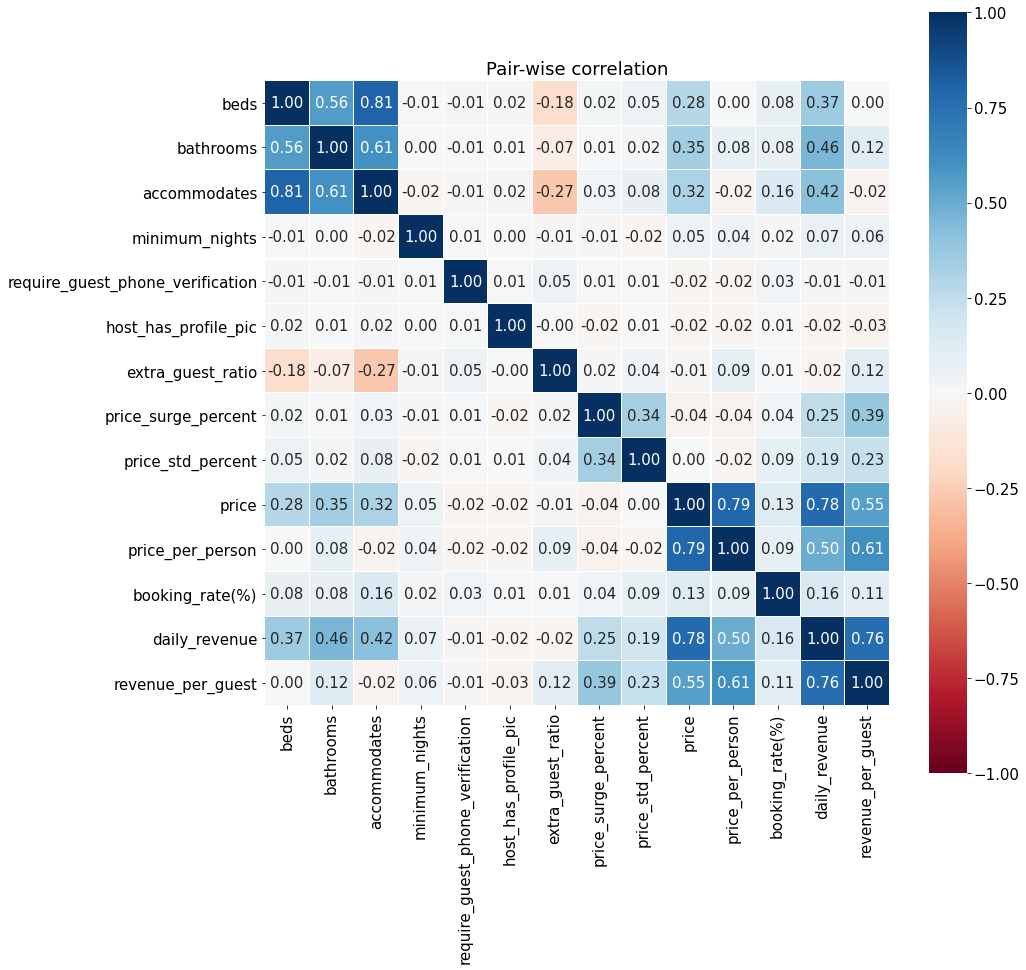

In [48]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,14))
sns.heatmap(listing_data_three_boroughs[corr_cols].astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True,fmt=".2f")
plt.title('Pair-wise correlation')

Key Findings !!!

### Modelling 

#### Data Cleaning for modelling

In [49]:
# One hot encoding
data_train = listing_data_three_boroughs.rename(index=str, columns={'neighbourhood_cleansed':'neighborhood'})
data_train = pd.get_dummies(data_train, columns=['property_type','neighborhood'], prefix=['property_type','neighborhood'])

In [50]:
data_train.tail(4)

,id,bathrooms,bedrooms,beds,room_type,accommodates,bed_type,guests_included,minimum_nights,maximum_nights,cancellation_policy,require_guest_phone_verification,require_guest_profile_picture,host_has_profile_pic,host_identity_verified,price,cleaning_fee,extra_people,booking_rate(%),daily_revenue,price_avg,price_std,price_per_person,accom_per_bed,baths_per_bed,extra_guest_ratio,price_surge_percent,price_std_percent,cleaning_fee_percent,guest_fee_percent,revenue_per_guest,property_type_Apartment,property_type_House,property_type_Other,neighborhood_City of London,neighborhood_Kensington and Chelsea,neighborhood_Westminster
16067,39867518,1.0,2.0,0.0,2,6,1,1,5,1125,0,0,0,1.0,0.0,149.0,0.0,0.0,100.000000,158.041096,158.041096,35.748065,24.833333,inf,inf,0.166667,6.067850,23.991990,0.000000,0.000000,26.340183,1,0,0,0,0,1
16068,39867538,1.0,2.0,3.0,2,4,1,4,3,1125,1,0,0,1.0,0.0,185.0,75.0,45.0,7.123288,185.000000,185.000000,0.000000,46.250000,1.333333,0.333333,1.000000,0.000000,0.000000,40.540541,24.324324,46.250000,1,0,0,0,1,0
16069,39868443,1.0,2.0,2.0,2,4,1,1,3,1125,2,0,0,1.0,0.0,90.0,65.0,0.0,17.534247,141.068493,141.068493,131.841702,22.500000,2.000000,0.500000,0.250000,56.742770,146.490780,72.222222,0.000000,35.267123,1,0,0,0,1,0
16070,39869282,1.5,1.0,1.0,2,6,1,1,1,90,0,0,0,1.0,0.0,187.0,30.0,0.0,85.205479,169.304110,169.304110,5.810006,31.166667,6.000000,1.500000,0.166667,-9.463043,3.106955,16.042781,0.000000,28.217352,1,0,0,0,0,1


In [51]:
# Get features and target
unused_cols = ['id', 'booking_rate(%)', 'daily_revenue','price_std', 'revenue_per_guest',
              'price_avg','cleaning_fee', 'extra_people']
features = [col for col in data_train.columns if col not in unused_cols]
train = data_train[features][:-4]
test = data_train[features][-4:]
target_booking = data_train['booking_rate(%)'][:-4]
target_revenue = data_train['daily_revenue'][:-4]

#### Fitting for modelling

In [52]:

ITERATIONS = 5000
N_FOLDS = 5

In [53]:
model_revenue = lgb.LGBMRegressor(num_leaves=50,
                        max_depth=10,
                        learning_rate=0.005,
                        n_estimators=ITERATIONS,
                        min_child_samples=25,
                        subsample=0.75,
                        subsample_freq=1,
                        feature_fraction=0.75,
                        reg_lambda=0.2,
                        random_state=2019,
                        n_jobs=4,
                        metrics='mae')

model_booking = lgb.LGBMRegressor(num_leaves=50,
                        max_depth=10,
                        learning_rate=0.005,
                        n_estimators=ITERATIONS,
                        min_child_samples=25,
                        subsample=0.75,
                        subsample_freq=1,
                        feature_fraction=0.75,
                        reg_lambda=0.2,
                        random_state=2019,
                        n_jobs=4,
                        metrics='mae')

In [54]:
# Preparing for out of fold training
oof_train = np.zeros(shape=(len(train)))

#### Models and Plots

In [55]:
# Training for revenue
print('TRAINING FOR REVENUE')
feature_importance_df_revenue = pd.DataFrame()
folds = KFold(n_splits=N_FOLDS, shuffle=True, random_state=2019)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target_revenue.values)):
    print('Fold no %i/%i'%(fold_+1,N_FOLDS))
    trn_data = train.iloc[trn_idx][features]
    trn_label = target_revenue.iloc[trn_idx]
    val_data = train.iloc[val_idx][features]
    val_label = target_revenue.iloc[val_idx]
    model_revenue.fit(X=trn_data, y=trn_label,
                     eval_set=[(trn_data, trn_label), (val_data, val_label)],
                     verbose=500,
                     early_stopping_rounds=100)

    oof_train[val_idx] = model_revenue.predict(val_data)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = model_revenue.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_revenue = pd.concat([feature_importance_df_revenue, fold_importance_df], axis=0)

score = mean_absolute_error(oof_train[:], target_revenue)
print('Training CV score: %.5f' %score)

TRAINING FOR REVENUE
Fold no 1/5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
Training until validation scores don't improve for 100 rounds
[500]	training's l1: 20.8938	valid_1's l1: 21.4162
[1000]	training's l1: 12.427	valid_1's l1: 13.7059
[1500]	training's l1: 11.2517	valid_1's l1: 12.8968
[2000]	training's l1: 10.5769	valid_1's l1: 12.4565
[2500]	training's l1: 10.0982	valid_1's l1: 12.1379
[3000]	training's l1: 9.68921	valid_1's l1: 11.9723
[3500]	training's l1: 9.38178	valid_1's l1: 11.7974
[4000]	training's l1: 9.09383	valid_1's l1: 11.6775
[4500]	training's l1: 8.86629	valid_1's l1: 11.5842
Early stopping, best iteration is:
[4432]	training's l1: 8.87976	valid_1's l1: 11.5585
Fold no 2/5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
Training until validation scores don't improve for 100 rounds
[500]	training's l1: 21.21

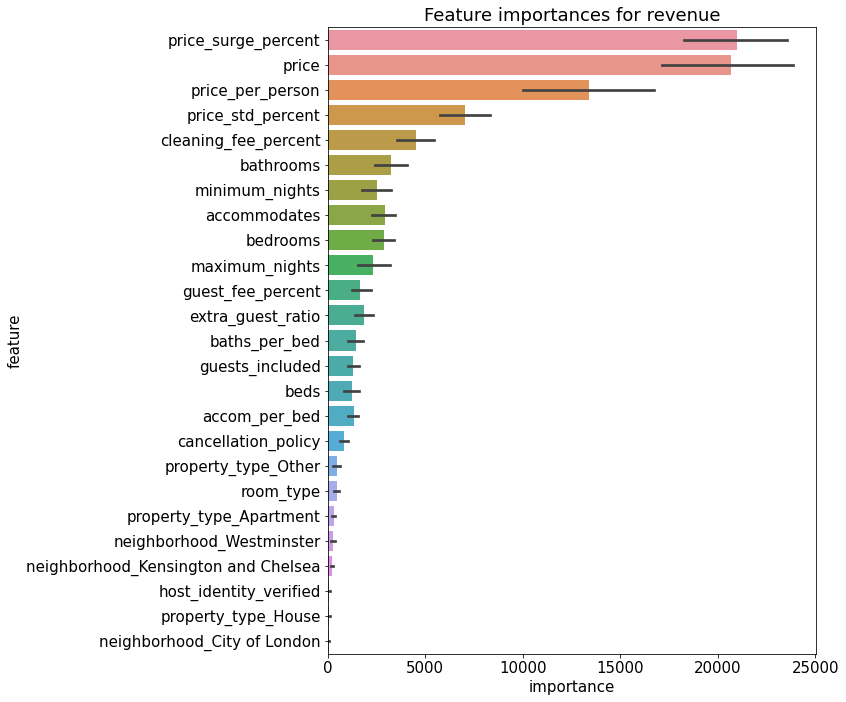

In [56]:
# Revenue Visualization
cols = (feature_importance_df_revenue[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:25].index)

best_features = feature_importance_df_revenue.loc[feature_importance_df_revenue.feature.isin(cols)]

plt.figure(figsize=(12,10))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('Feature importances for revenue')
plt.tight_layout()

In [57]:
# Training for booking
print('TRAINING FOR BOOKING')
feature_importance_df_booking = pd.DataFrame()
folds = KFold(n_splits=N_FOLDS, shuffle=True, random_state=2019)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target_booking.values)):
    print('Fold no %i/%i'%(fold_+1,N_FOLDS))
    trn_data = train.iloc[trn_idx][features]
    trn_label = target_booking.iloc[trn_idx]
    val_data = train.iloc[val_idx][features]
    val_label = target_booking.iloc[val_idx]
    model_booking.fit(X=trn_data, y=trn_label,
                     eval_set=[(trn_data, trn_label), (val_data, val_label)],
                     verbose=500,
                     early_stopping_rounds=100)

    oof_train[val_idx] = model_booking.predict(val_data)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = model_booking.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_booking = pd.concat([feature_importance_df_booking, fold_importance_df], axis=0)

score = mean_absolute_error(oof_train[:], target_booking)
print('Training CV score: %.5f' %score)

TRAINING FOR BOOKING
Fold no 1/5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
Training until validation scores don't improve for 100 rounds
[500]	training's l1: 26.1788	valid_1's l1: 27.139
[1000]	training's l1: 23.4472	valid_1's l1: 25.5443
[1500]	training's l1: 21.8982	valid_1's l1: 24.9029
[2000]	training's l1: 20.7111	valid_1's l1: 24.5463
[2500]	training's l1: 19.7314	valid_1's l1: 24.2958
[3000]	training's l1: 18.8623	valid_1's l1: 24.1124
[3500]	training's l1: 18.0869	valid_1's l1: 23.9626
[4000]	training's l1: 17.3907	valid_1's l1: 23.8626
[4500]	training's l1: 16.7447	valid_1's l1: 23.7813
[5000]	training's l1: 16.1608	valid_1's l1: 23.7086
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 16.1608	valid_1's l1: 23.7086
Fold no 2/5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
Training until validati

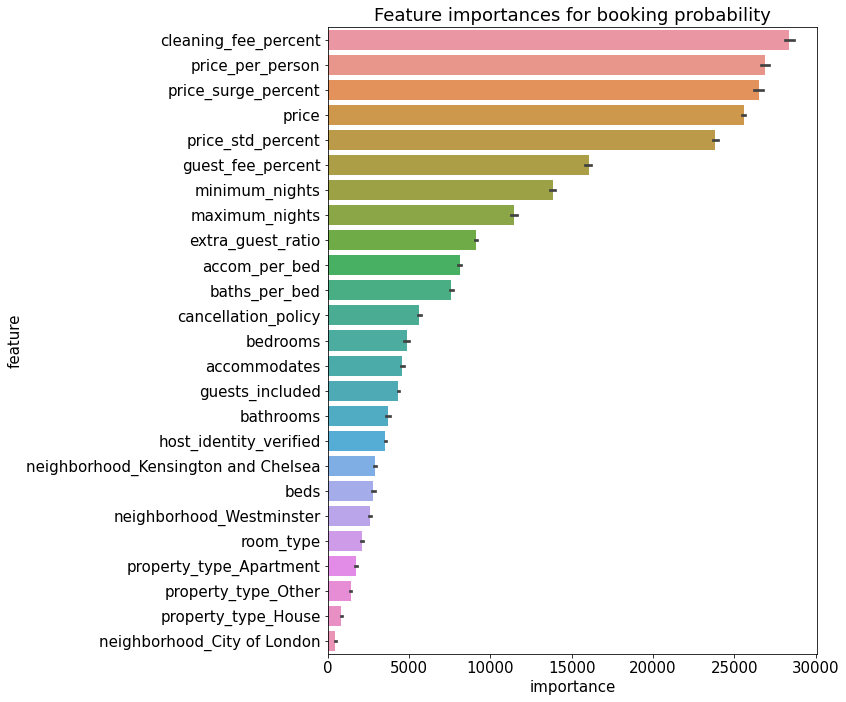

In [58]:
# Booking Visualization
cols = (feature_importance_df_booking[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:25].index)

best_features = feature_importance_df_booking.loc[feature_importance_df_booking.feature.isin(cols)]

plt.figure(figsize=(12,10))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('Feature importances for booking probability')
plt.tight_layout()

## Additional Codes for interactive tool

In [59]:
accommodates = widgets.Dropdown(
    options=[1, 2, 3, 4, 5, 6],
    value=2,
    description='Accommodates:',
    disabled=False,
)
bathrooms= widgets.Dropdown(
    options=[1, 2, 3],
    value=2,
    description='Bathrooms:',
    disabled=False,
)
bedrooms= widgets.Dropdown(
    options=[1, 2, 3, 4, 5, 6],
    value=2,
    description='Bedrooms:',
    disabled=False,
)
beds= widgets.Dropdown(
    options=[1, 2, 3, 4, 5, 6],
    value=2,
    description='Beds:',
    disabled=False,
)
cancellation= widgets.Dropdown(
    options=["strict", "moderate", "flexible"],
    value="moderate",
    description='Cancellation Policy:',
    disabled=False,
)
cleaning= widgets.Textarea(
    value='30',
    placeholder='Type fee',
    description='Cleaning fee:',
    disabled=False
)
neigh= widgets.Dropdown(
    options=["City of London", "Westminster", "Kensington and Chelsea"],
    value="City of London",
    description='Borough:',
    disabled=False,
)
property_type= widgets.Dropdown(
    options=["House", "Apartment", "Other"],
    value="Apartment",
    description='Property type:',
    disabled=False,
)
room_type= widgets.Dropdown(
    options=["Entire House", "Private Room", "Shared Room"],
    value="Private Room",
    description='Room type:',
    disabled=False,
)
guest_included= widgets.Dropdown(
    options=[1, 2, 3, 4, 5, 6],
    value=2,
    description='Guest Included:',
    disabled=False,
)
extra_people= widgets.Textarea(
    value='30',
    placeholder='Type',
    description='Extra People:',
    disabled=False
)
mini= widgets.Textarea(
    value='2',
    placeholder='Type',
    description='Minimum Nights:',
    disabled=False
)
maxi= widgets.Textarea(
    value='365',
    placeholder='Type',
    description='Maximum Nights:',
    disabled=False
)
price= widgets.Textarea(
    value='120',
    placeholder='Type',
    description='Price:',
    disabled=False
)



In [60]:
def s():
    if neigh.value == "City of London":
        cityoflondon=1
        westminster=0
        ken=0
    elif neigh.value =="Westminster":
        cityoflondon=0
        westminster=1
        ken=0
    elif neigh.value =="Kensington and Chelsea":
        cityoflondon=0
        westminster=0
        ken=1

    if property_type.value == "House":
        house=1
        apartment=0
        other=0
    elif property_type.value =="Apartment":
        house=0
        apartment=1
        other=0
    elif property_type.value =="Other":
        house=0
        apartment=0
        other=1


    case_study = {'price':  [price.value],
            'bathrooms': [bathrooms.value],
              'bedrooms': [bedrooms.value],
              'room_type': [room_type.value],
              'accommodates': [accommodates.value],
              'maximum_nights': [maxi.value],
              'minimum_nights': [mini.value],
              'property_type': [property_type.value],
              'neighborhood': [neigh.value],
              'extra_people': [extra_people.value],
              'cleaning_fee': [cleaning.value],
              'cancellation_policy': [cancellation.value],
              'beds': [beds.value],
               'guests_included': [guest_included.value],
                  'price_std': [30],
                  'price_avg': [price.value],
                  'property_type_House': [house],
                  'property_type_Other': [apartment],
                  'property_type_Apartment': [other],
                  'neighborhood_Kensington and Chelsea': [ken],
                  'neighborhood_Westminster':[westminster] ,
                  'neighborhood_City of London':[cityoflondon] ,
                  'require_guest_phone_verification' :[0],
                  'require_guest_profile_picture' :[0],
                  'require_guest_phone_verification' :[0],
                  'host_has_profile_pic': [0],
                  'host_identity_verified': [0]
            }
    #case_study_df = pd.DataFrame (case_study, columns = ["price", "bathrooms", "bedrooms", "room_type", "accommodates", "maximum_nights",
     #                                                   "minimum_nights", "propert_type", "neighbourhood", "extra_people", "cleaning_fee"])

    case_study_df = pd.DataFrame.from_dict(case_study)

    case_study_df['price'] = case_study_df['price'].replace('[\$,]', '', regex=True).astype(float)
    case_study_df['maximum_nights'] = case_study_df['maximum_nights'].replace('[\$,]', '', regex=True).astype(float)
    case_study_df['minimum_nights'] = case_study_df['minimum_nights'].replace('[\$,]', '', regex=True).astype(float)
    case_study_df['cleaning_fee'] = case_study_df['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
    case_study_df['extra_people'] = case_study_df['extra_people'].replace('[\$,]', '', regex=True).astype(float)
    case_study_df['price_avg'] = case_study_df['price_avg'].replace('[\$,]', '', regex=True).astype(float)

    case_study_df['accom_per_bed'] = case_study_df['accommodates']/case_study_df['beds']
    case_study_df['baths_per_bed'] = case_study_df['bathrooms']/case_study_df['beds']
    case_study_df['extra_guest_ratio'] = case_study_df['guests_included']/case_study_df['accommodates']
    case_study_df['price_surge_percent'] = (listing_data_three_boroughs['price_avg']/listing_data_three_boroughs['price']-1)*100
    case_study_df['price_std_percent'] = case_study_df['price_std']/case_study_df['price']*100
    case_study_df['cleaning_fee_percent'] = case_study_df['cleaning_fee']/case_study_df['price']*100
    case_study_df['guest_fee_percent'] = case_study_df['extra_people']/case_study_df['price']*100
    case_study_df['room_type'] = case_study_df['room_type'].replace({'Shared Room':0, 'Private Room':1, 'Entire House':2})
    case_study_df['cancellation_policy'] = case_study_df['cancellation_policy'].replace({'flexible':0, 'moderate':1, 'strict':2})

    case_study_df= case_study_df.drop(['price_std'], axis=1)
    case_study_df= case_study_df.drop(['price_avg'], axis=1)
    case_study_df= case_study_df.drop(['neighborhood'], axis=1)
    case_study_df= case_study_df.drop(['property_type'], axis=1)
    booking_predict= model_booking.predict(case_study_df)
    revenue_predict = model_revenue.predict(case_study_df)
    print("Booking Precit: {0}, Revenue Predict: {1}".format(booking_predict, revenue_predict))
    

In [61]:
if neigh.value == "City of London":
    cityoflondon=1
    westminster=0
    ken=0
elif neigh.value =="Westminster":
    cityoflondon=0
    westminster=1
    ken=0
elif neigh.value =="Kensington and Chelsea":
    cityoflondon=0
    westminster=0
    ken=1
    
if property_type.value == "House":
    house=1
    apartment=0
    other=0
elif property_type.value =="Apartment":
    house=0
    apartment=1
    other=0
elif property_type.value =="Other":
    house=0
    apartment=0
    other=1
        

case_study = {'price':  [price.value],
        'bathrooms': [bathrooms.value],
          'bedrooms': [bedrooms.value],
          'room_type': [room_type.value],
          'accommodates': [accommodates.value],
          'maximum_nights': [maxi.value],
          'minimum_nights': [mini.value],
          'property_type': [property_type.value],
          'neighborhood': [neigh.value],
          'extra_people': [extra_people.value],
          'cleaning_fee': [cleaning.value],
          'cancellation_policy': [cancellation.value],
          'beds': [beds.value],
           'guests_included': [guest_included.value],
              'price_std': [0],
              'price_avg': [price.value],
              'property_type_House': [house],
              'property_type_Other': [apartment],
              'property_type_Apartment': [other],
              'neighborhood_Kensington and Chelsea': [ken],
              'neighborhood_Westminster':[westminster] ,
              'neighborhood_City of London':[cityoflondon] ,
              'require_guest_phone_verification' :[0],
              'require_guest_profile_picture' :[0],
              'require_guest_phone_verification' :[0],
              'host_has_profile_pic': [0],
              'host_identity_verified': [0]
        }
#case_study_df = pd.DataFrame (case_study, columns = ["price", "bathrooms", "bedrooms", "room_type", "accommodates", "maximum_nights",
 #                                                   "minimum_nights", "propert_type", "neighbourhood", "extra_people", "cleaning_fee"])
    
case_study_df = pd.DataFrame.from_dict(case_study)

case_study_df['price'] = case_study_df['price'].replace('[\$,]', '', regex=True).astype(float)
case_study_df['maximum_nights'] = case_study_df['maximum_nights'].replace('[\$,]', '', regex=True).astype(float)
case_study_df['minimum_nights'] = case_study_df['minimum_nights'].replace('[\$,]', '', regex=True).astype(float)
case_study_df['cleaning_fee'] = case_study_df['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
case_study_df['extra_people'] = case_study_df['extra_people'].replace('[\$,]', '', regex=True).astype(float)
case_study_df['price_avg'] = case_study_df['price_avg'].replace('[\$,]', '', regex=True).astype(float)

case_study_df['accom_per_bed'] = case_study_df['accommodates']/case_study_df['beds']
case_study_df['baths_per_bed'] = case_study_df['bathrooms']/case_study_df['beds']
case_study_df['extra_guest_ratio'] = case_study_df['guests_included']/case_study_df['accommodates']
case_study_df['price_surge_percent'] = (listing_data_three_boroughs['price_avg']/listing_data_three_boroughs['price']-1)*100
case_study_df['price_std_percent'] = case_study_df['price_std']/case_study_df['price']*100
case_study_df['cleaning_fee_percent'] = case_study_df['cleaning_fee']/case_study_df['price']*100
case_study_df['guest_fee_percent'] = case_study_df['extra_people']/case_study_df['price']*100
case_study_df['room_type'] = case_study_df['room_type'].replace({'Shared Room':0, 'Private Room':1, 'Entire House':2})
case_study_df['cancellation_policy'] = case_study_df['cancellation_policy'].replace({'flexible':0, 'moderate':1, 'strict':2})

case_study_df= case_study_df.drop(['price_std'], axis=1)
case_study_df= case_study_df.drop(['price_avg'], axis=1)
case_study_df= case_study_df.drop(['neighborhood'], axis=1)
case_study_df= case_study_df.drop(['property_type'], axis=1)
booking_predict= model_booking.predict(case_study_df)
revenue_predict = model_revenue.predict(case_study_df)

def f(beds, price, maxi, mini, extra_people, guest_included, room_type, property_type, neigh, cancellation, cleaning, bedrooms, bathrooms, accommodates):
   s()

#out = widgets.interactive_output(f, {'a': a,'b': b, 'c':c },)
#out.layout = {"border":"1px solid red"}
          
out = widgets.interactive_output(f, {'beds': beds, 'price': price, 'maxi': maxi, "mini": mini, "extra_people": extra_people, "guest_included": guest_included, "room_type": room_type, "property_type": property_type, "neigh": neigh, "cancellation": cancellation,
                                     "cleaning": cleaning, "bedrooms": bedrooms, "bathrooms": bathrooms, "accommodates": accommodates})
out.layout = {"border":"1px solid red"}


# Executive Brief

Recently, The "sharing economy" has been quite popular increasingly. People create a community to share their gardens, cars, houses and even their foods. This increasing popularity results in emerging large-scale companies to support sharing economy with the help of internet platforms such as Uber and Airbnb (Cheng and Foley, 2007). As a result, this emerging enterprises can connect small entrepreneurs to share their properties so that both large-scale companies and small entrepreneurs can make profit of them. Perhaps one of the most popular applications for sharing economy is AirBnb. It is an internet platform that gives opportunities to multiple house owners to share their house or room. Basically, it is a peer to peer short-term rental servşce that connect both owners and renters. AirBnb has more than 4 million users and over 300,000 listings all the world (Nguyen, 2014). As all the owners are seeking for maximum revenue by renting their properties, this report will provide a comprehensive analusis of AirBnb activities in selected neighbourhoods in London to understand the outputs of revenue and booking rate. There are many inputs taken into account in this report such as price, propert and room type, neighbourhood etc.  

The data is taken from InsideAirBnb which is a famous open-access dataset that provide detailed informations about hosts, properties, reviews and this dataset is created by Murray Cox. Due to the limited time and technology, one year time period data is used for analysing. Listing and calendar data in 2019-2020 is used. The aim of this report is helping hosts who make plan to enter AirBnb universe to professionalise better by doing deep analysing on AirBnb data. **The main question is if the inexperienced and new-comer hosts want to enter AirBnb business in London, is it possible to give some suggestions in terms of pricing and housing strategy so that they can maximise their revenue?** 

In terms of methodology, the report is divided into four main parts. Firstly, general overview of listing data is observed in order to select top 3 boroughs in London regarding to price and number of listings. Secondly, revenue and booking time in 2019-20 are scrapped from calendar data in InsideAirbnb dataset. Thirdly, the types of input data are defined and these are: 

* Property details: number of rooms, bed, room and apartment types and neighbourhoods 
* Host details: amount of allowed extra guests, cancellation policy, veritification types
* Pricing details: cleaning fee, price surging and per person 

The last step is generating LGBM (light gradient boosting machine) method to predict revenue and booking probability. LightGBM is an open source gradient boosting framework developed by Microsoft. It is generally utilised for forecasting values by training given datasets to machine. It is one of the fundamental tools of machine learning. Also, mean absolute error for revenues is applied. 

![1](https://github.com/ucfnofe/i2pcoursework/blob/master/outputs/1.png?raw=true) 
##### Figure 1



As shown in figure 1, in terms of average price per boroughs, the top three boroughs are Kensington and Chelsea(6018 listings), Westminster(9588) and City of London(465). Because of limited technology, it is assumed that new-comer hosts own property in these top boroughs. This report is only focus on these boroughs. 

If we look at price and booking rate over time as shown in figure 2 and 3, there are some interesting outputs. For example, average price in three boroughs are highest on January and it is mostly because in winter times, booking rates are higher than other periods of time. On the contrary, there are slightly increasing in summer times for the price values. In addition, average price is 233 USD and average booking percentage is %42. 

![image info](https://github.com/ucfnofe/i2pcoursework/blob/master/outputs/2.png?raw=true)
##### Figure 2
![image info](https://github.com/ucfnofe/i2pcoursework/blob/master/outputs/3.png?raw=true)
##### Figure 3

In order to understand the relationship between parameters roughly before going into deep analysis, figure 4 shows the correlations between variables. Obviously, the bigger property result in higher price and revenue according to correlations. But, interestingly cancellation policy and host policies have not significant impact on revenue. For the booking rate, there are not significant correlations but the price and the number of accommodates may effect it. 

![image.png](https://github.com/ucfnofe/i2pcoursework/blob/master/outputs/4.png?raw=true)
##### Figure 4

As a result of LightGBM analysis, feature importance for revenue and booking percentage are drawn as shown in figure 5 and figure 6. We may get several observations from this model. First of all, for the revenue, types of prices like price per person, price surging, cleaning price and standart derivation of price play an important role for revenue. For newcomers, to maximise their revenue, it is essential to create good pricing strategy. In addition, property details such as number of bathrooms and bedrooms are also important. Interestingly, cancellation policy and neighbourhood are not effective for revenue.

![image.png](https://github.com/ucfnofe/i2pcoursework/blob/master/outputs/5.png?raw=true)
##### Figure 5

For booking percentage, it is similar to feature importances for revenue. Again, types of price is an effective for booking probabilty. However, differently, cleaning fee percent is more important than other types of price features. Users pay attention and care to the percentage of cleaning fee, thus, it affects the booking percentage. On the contrary to revenue, cancellation policy is more important for booking rates rather than revenue. Maximum and minimum nights parameters are more influential than property details.  

![image.png](https://github.com/ucfnofe/i2pcoursework/blob/master/outputs/6.png?raw=true)
##### Figure 6

In summary, this report include the detailed analysis of revenue and booking rate. The analysis procedure is taking first three boroughs in London regarding to price and number of listings and doing LightGBM analysis to create predictive model. With help of LightGBM, interactive case study model is created as shown above. Potential newcomers can get an idea as a series of case studies using the interactive tool below. 

In [62]:
widgets.VBox([accommodates, bathrooms, bedrooms, cancellation, cleaning, neigh,property_type, room_type, price, mini,maxi, extra_people,beds,guest_included, out ])

## References

Cheng, M., &amp; Foley, C. (2018). The sharing economy and digital discrimination: The case of Airbnb. *International Journal of Hospitality Management*, 70, 95-98. doi:10.1016/j.ijhm.2017.11.002


G. Ke, Q. Meng, T. Finley, T. Wang, W. Chen, W. Ma, Q. Ye, T.-Y. Liu
LightGBM: a highly efficient gradient boosting decision tree
Adv. Neur. Inf. Process. Sys., 30 (2017), pp. 3146-3154


Nguyen, Q. (2014). A Study of Airbnb as a Potential Competitor of the Hotel Industry. *UNLV Theses, Dissertations, Professional Papers, and Capstones.*

**For Coding**

A Deep Dive into Geospatial Analysis : https://github.com/ResidentMario/boston-airbnb-geo

Airbnb San Francisco Data Analysis : https://github.com/pauljeon/airbnb-data-analysis

Predicting-Airbnb-host-revenue-in-Seattle : https://github.com/dmnguyen92/Predicting-Airbnb-host-revenue-in-Seattle

Traveling to Paris, France? How to get the biggest bang from your buck using Airbnb : https://github.com/eherdter/Airbnb_analysis